# Quick Start

We presently run through a simple example of how `kulprit` provides a simple and effective model selection procedure in the case of linear regression.

To begin with, we import the necessary dependencies for the initial model fitting (for which we use `bambi`) and data handling. The `kulprit` package provides all the machinery for model selection once we have fitted a `bambi` model.

In [1]:
import pandas as pd
import numpy as np

import bambi as bmb
import kulprit as kpt

import arviz as az
import matplotlib.pyplot as plt

In [2]:
az.style.use('arviz-white')

## A synthetic example

To illustrate the use of `kulprit`, we begin with a linear regression with synthetic data.

In [3]:
RANDOM_SEED = 453
np.random.seed(RANDOM_SEED)
x1 = np.random.normal(0, 0.5, 121)
x2 = np.random.normal(0, 1, 121)
y = np.random.normal(2 * x1 + 3, 0.25)
data = pd.DataFrame({"x1": x1, "x2": x2, "y": y})

We presently look to fit a linear regression to these data, namely the model 

$$
y \sim \mathcal{N}(\beta_0 + \beta_1 x_1 + \beta_2 x_2, \sigma)
$$

with $\sigma>0$ and $\beta_i \in \mathbb{R}$, in which we treat $y$ as our variate, and $x_1$ and $x_2$ as the covariates. This is cleanly communicated to `bambi` using the formula `"y ~ x1 + x2"`. We will use the default `bambi` priors over $\beta_i$ and $\sigma$, on which more information can be found in [the bambi docs](https://bambinos.github.io/bambi/).

In [4]:
model = bmb.Model("y ~ x1 + x2", data)
idata = model.fit(random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, x1, x2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


## Model selection

We now perform the model selection procedure provided by `kulprit` by instanciating the `ProjectionPredictive` class.

In [5]:
ppi = kpt.ProjectionPredictive(model, idata)

And then we perform a search. Kulprit will start from the intercept-only model and it will keep adding one variable at a time until we have a model with all the variables, as in the original model. Notice that at each step kulprit has to "decide" which variable to add to the model. For this simple model we only have two possible search paths:

* intercept --> intercept + x1 --> intercept + x1 + x2
* intercept --> intercept + x2 --> intercept + x1 + x2

Notice that as we add variables the number of alternative path will grow very fast. From the following cell we can see that the first path is the one that is chosen.

In [6]:
ppi.search()
ppi

  0 ['Intercept']
  1 ['Intercept', 'x1']
  2 ['Intercept', 'x1', 'x2']

In [7]:
ppi.path

{0: ['Intercept'], 1: ['Intercept', 'x1'], 2: ['Intercept', 'x1', 'x2']}

Having performed the search, it is now our interest to identify the submodel with the fewest parameters that most closely resembles the reference model. We do so by computing the expected log-pointwise density (ELPD) using leave-one-out cross-validation (LOO-CV).

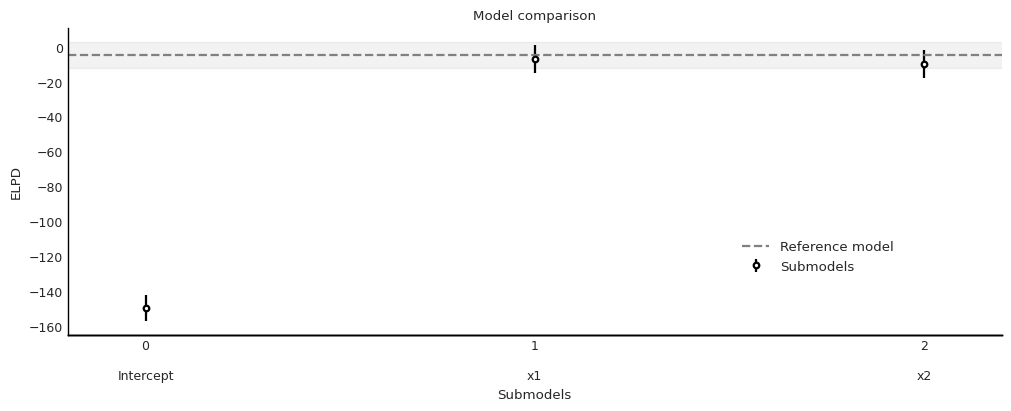

In [12]:
cmp, ax = ppi.compare(plot_kwargs={"xlabel_rotation": 0});

From these results we can see that the difference between the reference model and the model with only one parameter is very small. Thus, we may want to keep this smaller model. In the following cell we can see that the model is `y ~ x1`.

In [9]:
submodel = ppi.project(1)
submodel

['Intercept', 'x1']

Having achieved this submodel, we can more closely investigate the posterior distributions of its parameters with `ArviZ`.

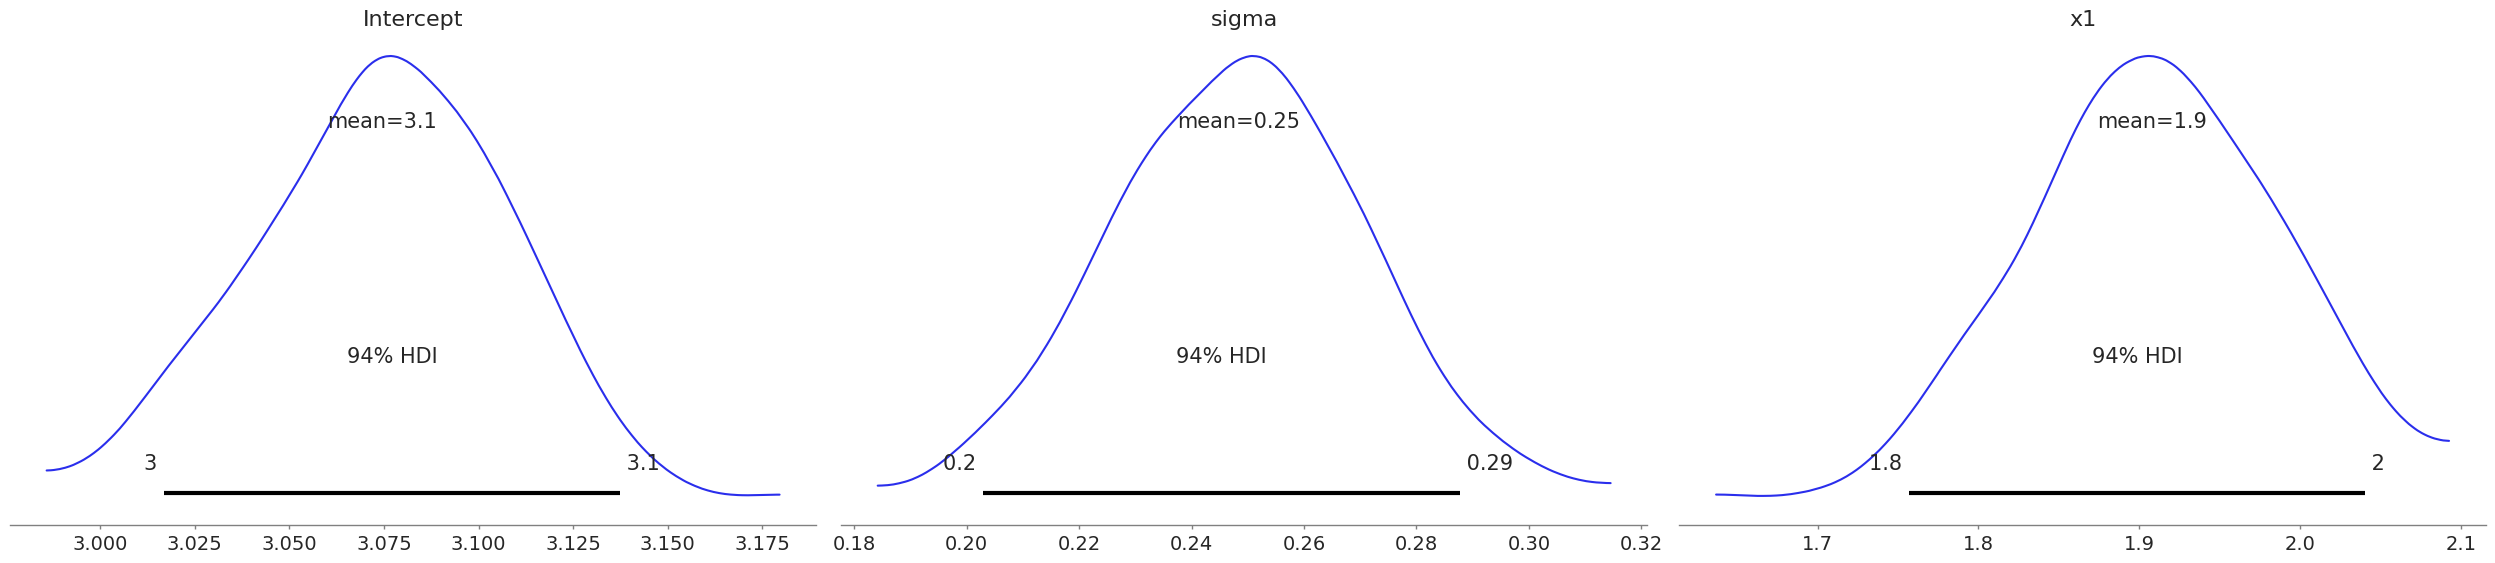

In [10]:
ax = az.plot_posterior(submodel.idata);

Or we can compare the posterior distributions of the parameters of the reference model and the submodel of size 2, i.e. the model with as many parameters as the reference model. We can see that their posterior distributions are very similar.

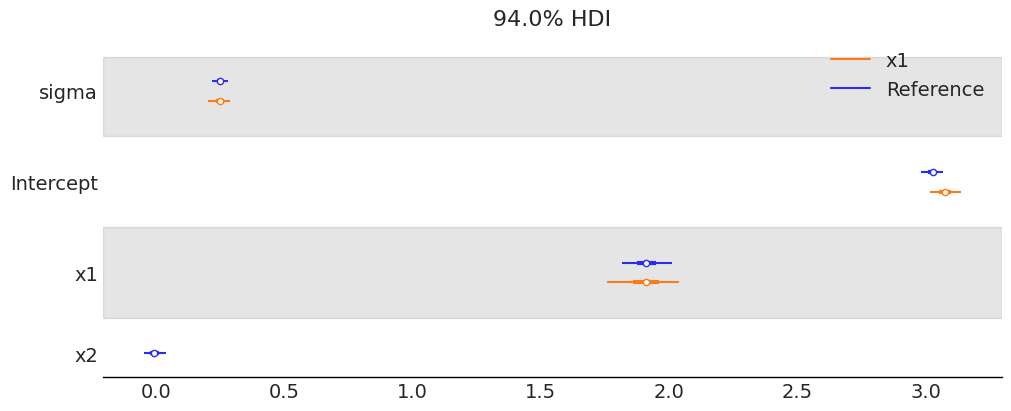

In [11]:
ppi.plot_densities(submodels=[1], kind="forest", figsize=(10, 4));

## OK, but what is going on?

At each step, kulprit has to compute the posterior distribution of each submodel and then evaluate its predictive performance. The computation of the posterior distribution is not done with MCMC as in `bambi`, instead kulprit "projects" the reference model (the model with all the variables) onto a given submodel. 

By projection, we mean that for a reference model posterior $p(\boldsymbol y \mid \boldsymbol \beta^\ast)$ with $\boldsymbol \beta^\ast = (\beta_0, \beta_1, \beta_2)^T$, and a parameter subset $\boldsymbol \beta^\perp \subset \boldsymbol \beta^\ast$, we find the parameter values of $\boldsymbol \beta^\perp$ according to the solution to the optimization problem

$$
\boldsymbol\beta^\perp = \arg\min_{\boldsymbol\beta} d \left( p(\boldsymbol y\mid \boldsymbol\beta),\, p(\boldsymbol y\mid \boldsymbol\beta^\ast) \right)
$$

In this formulation, $d(\cdot, \cdot)$ is the Kullback-Leibler distance metric. In a word, we look to achieve the values of $\boldsymbol \beta^\perp$ such that the posterior of their associated model is most close to the reference model. 